# How do NPDES permit limits differ between permits issued before TMDLs (incumbents) vs permits issued after TMDLs (newcomers)?
Author: Ryan Treves

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import warnings

# Suppress warning messages
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000
# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [16]:
tmdls = pd.read_csv('all_actions.csv', parse_dates=['TMDLDate'], date_parser=lambda t: pd.to_datetime(t, errors='coerce')).drop('Unnamed: 0', axis=1).rename(columns={'assessmentUnitIdentifier':'AUID'})
huc_npdes_permit_links = pd.read_csv('huc_npdes_permit_links.csv', dtype={'attributes.WBD_HUC12': object}).rename(columns={'attributes.WBD_HUC12': 'HUC-12'})
huc_AUID_links = pd.read_csv('huc_AUID_links.csv', dtype={'attributes.huc12': object}).rename(columns={'attributes.assessmentunitidentifier':'AUID', 'attributes.huc12': 'HUC-12'})
AL_permit_data = pd.read_csv('AL_permit_data.csv', parse_dates=['effective_date', 'issue_date', 'original_effective_date', 'original_issue_date', 'expiration_date', 'retirement_date', 'termination_date'], date_parser=lambda t: pd.to_datetime(t, errors='coerce'))

# Drop permits without an issue date
AL_permit_data.dropna(subset='issue_date', inplace=True)

In [17]:
tmdls_merged = tmdls.drop_duplicates().merge(huc_AUID_links, on='AUID', how='inner').merge(huc_npdes_permit_links, on='HUC-12', how='inner')
del tmdls
del huc_AUID_links
del huc_npdes_permit_links

### Test state: Alabama

In [18]:
# Read in DMR data for limit comparisons
AL_dmrs = pd.read_csv('AL_dmrs.csv', parse_dates=['limit_begin_date', 'limit_end_date'], date_parser=lambda t: pd.to_datetime(t, errors='coerce'))
# Extract only limits from DMR data
AL_limits = AL_dmrs.drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'parameter_desc', 'limit_value_type_code', 'limit_value_nmbr', 'statistical_base_code', 'limit_begin_date', 'version_nmbr'])

# Merge with `permit_dates` to get permit issuance date
AL_limits = AL_limits.merge(AL_permit_data, on=['npdes_permit_id', 'version_nmbr'], how='left')
del AL_permit_data

In [19]:
# Just look at Alabama TMDLs
tmdls_merged_AL = tmdls_merged[tmdls_merged['state_code'] == 'AL']

# Merge limit data with TMDL data
tmdls_limits_merged = tmdls_merged_AL.merge(AL_limits, on='npdes_permit_id', how='inner')

# Drop limits that expired, retired, or were terminated before the TMDL date
tmdls_limits_merged = tmdls_limits_merged[~(tmdls_limits_merged['expiration_date'] <= tmdls_limits_merged['TMDLDate']) &
                                            ~(tmdls_limits_merged['retirement_date'] <= tmdls_limits_merged['TMDLDate']) &
                                            ~(tmdls_limits_merged['termination_date'] <= tmdls_limits_merged['TMDLDate'])]

In [20]:
# Define incumbency
tmdls_limits_merged['incumbent'] = (tmdls_limits_merged['issue_date'] <= tmdls_limits_merged['TMDLDate'])

In [21]:
tmdls_limits_merged['incumbent'].value_counts()

False    327388
True     160562
Name: incumbent, dtype: int64

In [22]:
# Define function to plot incumbents vs newcomers for a given parameter
def plot_incumbent_comparison(data, parameter, bw=0.1):
    value_types = data['limit_value_type_code'].unique()
    fig, axes = plt.subplots(1, len(value_types), figsize=(15, 5))
    fig.suptitle(parameter + '\n (Orange=incumbent, Blue=newcomer)')
    for i in range(0, len(value_types)):
        sns.kdeplot(ax=axes[i], data=data[(data['incumbent']==True) & (data['limit_value_type_code']==value_types[i])], x='limit_value_standard_units', bw_adjust=bw, color='orange')
        sns.kdeplot(ax=axes[i], data=data[(data['incumbent']==False) & (data['limit_value_type_code']==value_types[i])], x='limit_value_standard_units', bw_adjust=bw)
        axes[i].set_title('Limit value type: ' + value_types[i] + ' (' + str(len(data[(data['incumbent']==True) & (data['limit_value_type_code']==value_types[i])])) + ' inc., ' + str(len(data[(data['incumbent']==False) & (data['limit_value_type_code']==value_types[i])])) + ' new)')

In [96]:
AL_E_coli = tmdls_limits_merged[(tmdls_limits_merged['pollutantName']=='ESCHERICHIA COLI (E. COLI)') & (tmdls_limits_merged['parameter_desc']=='E. coli')].dropna(subset='limit_value_standard_units')
AL_pH = tmdls_limits_merged[(tmdls_limits_merged['pollutantName']=='PH') & (tmdls_limits_merged['parameter_desc']=='pH')].dropna(subset='limit_value_standard_units')
AL_P = tmdls_limits_merged[(tmdls_limits_merged['pollutantName']=='PHOSPHORUS, TOTAL') & (tmdls_limits_merged['parameter_desc'].apply(lambda x: x in ['Phosphorus, Total As P', 'Phosphorus, total [as P]', 'Phosphorous, total elemental', 'Phosphorous, total organic [as P]', 'Phosphorous, total recoverable']))].dropna(subset='limit_value_standard_units')
AL_TSS = tmdls_limits_merged[(tmdls_limits_merged['pollutantName']=='TOTAL SUSPENDED SOLIDS (TSS)') & (tmdls_limits_merged['parameter_desc'] == 'Solids, total suspended')].dropna(subset='limit_value_standard_units')

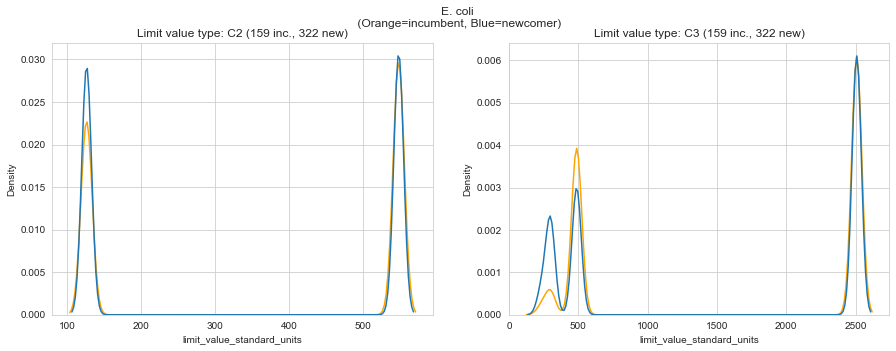

In [97]:
plot_incumbent_comparison(AL_E_coli, 'E. coli')

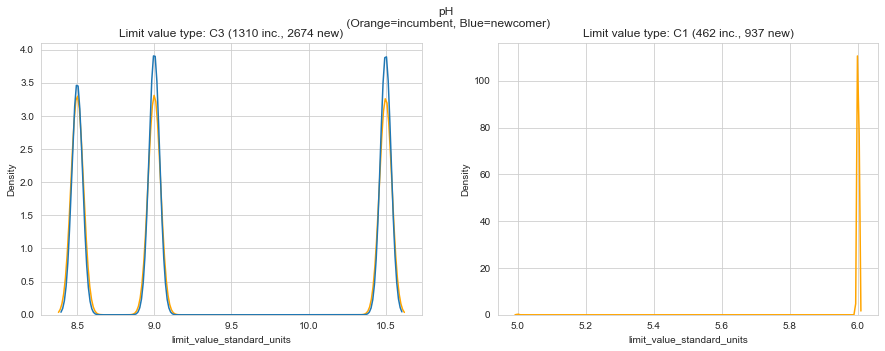

In [98]:
plot_incumbent_comparison(AL_pH, 'pH', bw=0.2)

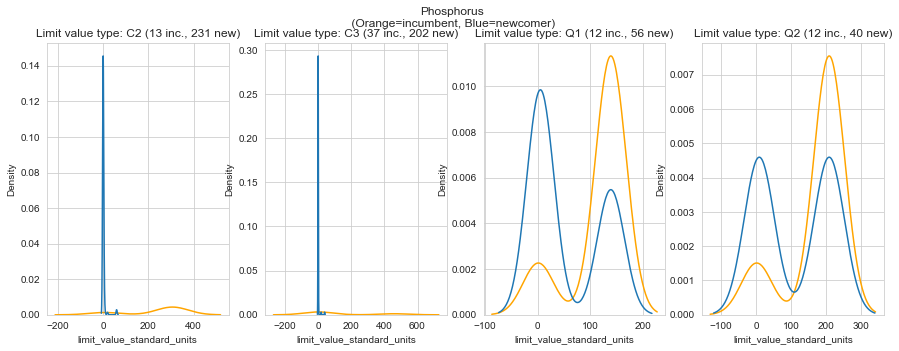

In [99]:
plot_incumbent_comparison(AL_P, 'Phosphorus', bw=0.9)

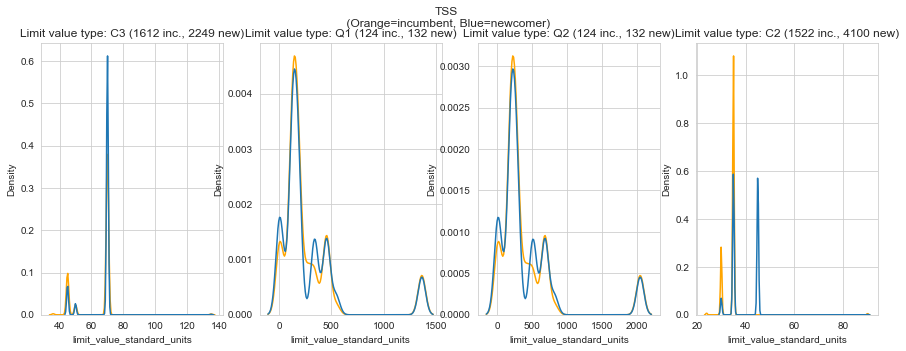

In [100]:
plot_incumbent_comparison(AL_TSS, 'TSS', bw=0.3)

### Can we perform statistical inference on these differences?

In [102]:
# Concatenate all matched data above
to_test = pd.concat([AL_E_coli, AL_P, AL_TSS, AL_pH])

In [151]:
# Group by limit type
grouped = to_test.groupby(['pollutantName', 'limit_value_type_code', 'statistical_base_code', 'facility_type_indicator', 'wastewater_permit_flag', 'stormwater_permit_flag', 'sewage_permit_flag', 'individual_permit_flag', 'major_permit_flag', 'actionIdentifier'], as_index=False).nunique()

# Only retain permit limit types with more than one permittee, as well as both incumbents and newcomers
grouped = grouped[(grouped['npdes_permit_id']>1) & (grouped['incumbent']>1)]

In [152]:
p_values = pd.DataFrame()

for i in range(0, len(grouped)):
    # Pick out one permit limit type
    permit_limit_type = grouped.iloc[[i]][['pollutantName', 'limit_value_type_code', 'statistical_base_code', 'facility_type_indicator', 'wastewater_permit_flag', 'stormwater_permit_flag', 'sewage_permit_flag', 'individual_permit_flag', 'major_permit_flag', 'actionIdentifier']].merge(to_test, on=['pollutantName', 'limit_value_type_code', 'statistical_base_code', 'facility_type_indicator', 'wastewater_permit_flag', 'stormwater_permit_flag', 'sewage_permit_flag', 'individual_permit_flag', 'major_permit_flag', 'actionIdentifier'], how='inner')

    # Create ID tracking unique limits
    permit_limit_type['unique_lim_id'] = permit_limit_type['npdes_permit_id'] + '_' + permit_limit_type['version_nmbr'].astype(str) + '_' + permit_limit_type['perm_feature_nmbr'].astype(str) + '_' + permit_limit_type['limit_begin_date'].astype(str)

    # Drop non-unique limits
    permit_limit_type.drop_duplicates('unique_lim_id', inplace=True)

    # Optional, calculate stats
    #stats = test.groupby('incumbent').agg(limit_mean=pd.NamedAgg(column='limit_value_standard_units', aggfunc=lambda x: x.mean()), limit_mean_SE=pd.NamedAgg(column='limit_value_standard_units', aggfunc=lambda x: x.sem()), unique_limits=pd.NamedAgg(column='unique_lim_id', aggfunc=lambda x: x.nunique()))

    # Calculate Welch's t-test (two-pop t-test with diff variances) and save p-value
    p_value = ss.ttest_ind(permit_limit_type[permit_limit_type['incumbent']==True]['limit_value_standard_units'], permit_limit_type[permit_limit_type['incumbent']==False]['limit_value_standard_units'], alternative='greater').pvalue
    p_values = pd.concat([p_values, pd.Series(p_value)]).dropna()

Text(0.5, 1.0, "Alt Hypothesis: incumbents' mean limit value > newcomers' mean limit value, \n comparing similar facilities under the same TMDL in Alabama. \n Phosphorus, pH, TSS, E. coli TMDLs included. (n=19 tests)")

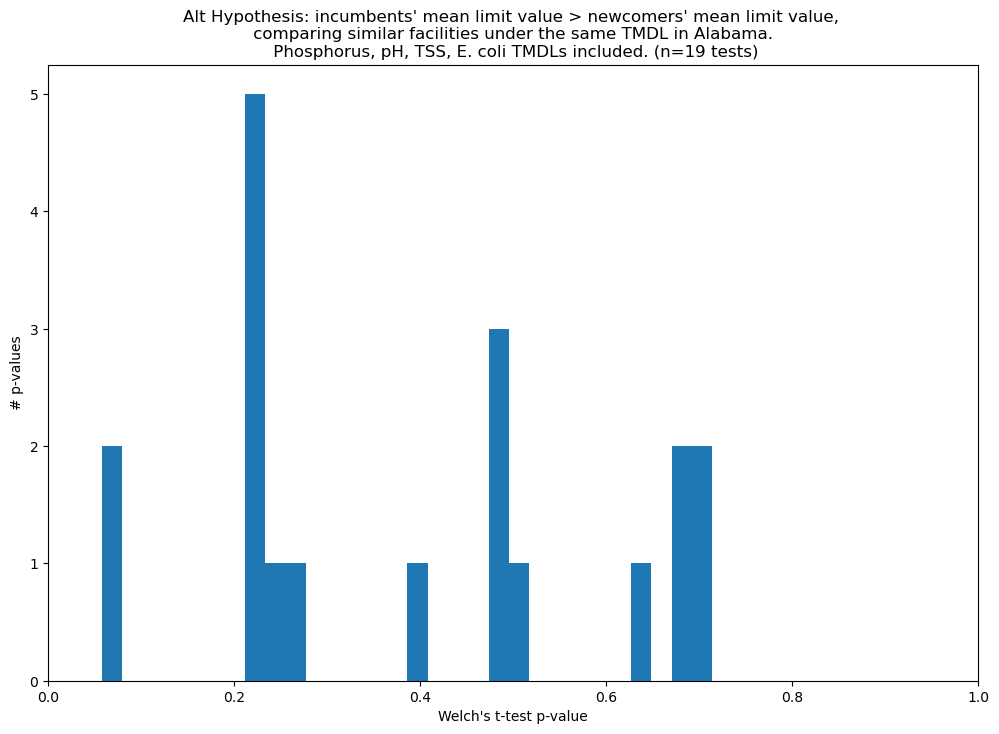

In [153]:
plt.style.use('default')
plt.figure(figsize=(12,8))
plt.hist(p_values, bins=30);
plt.xlim((0, 1));
plt.xlabel('Welch\'s t-test p-value')
plt.ylabel('# p-values')
plt.title('Alt Hypothesis: incumbents\' mean limit value > newcomers\' mean limit value, \n comparing similar facilities under the same TMDL in Alabama. \n Phosphorus, pH, TSS, E. coli TMDLs included. (n=' + str(len(p_values)) + ' tests)')

In [154]:
# Group by limit type
grouped = to_test.groupby(['pollutantName', 'limit_value_type_code', 'statistical_base_code', 'actionIdentifier'], as_index=False).nunique()

# Only retain permit limit types with more than one permittee, as well as both incumbents and newcomers
grouped = grouped[(grouped['npdes_permit_id'] > 1) & (grouped['incumbent'] > 1)]
p_values = pd.DataFrame()

for i in range(0, len(grouped)):
    # Pick out one permit limit type
    permit_limit_type = grouped.iloc[[i]][
        ['pollutantName', 'limit_value_type_code', 'statistical_base_code', 'actionIdentifier']].merge(to_test,
                                    on=['pollutantName', 'limit_value_type_code', 'statistical_base_code', 'actionIdentifier'], how='inner')

    # Create ID tracking unique limits
    permit_limit_type['unique_lim_id'] = permit_limit_type['npdes_permit_id'] + '_' + permit_limit_type[
        'version_nmbr'].astype(str) + '_' + permit_limit_type['perm_feature_nmbr'].astype(str) + '_' + permit_limit_type['limit_begin_date'].astype(str)

    # Drop non-unique limits
    permit_limit_type.drop_duplicates('unique_lim_id', inplace=True)

    # Optional, calculate stats
    #stats = test.groupby('incumbent').agg(limit_mean=pd.NamedAgg(column='limit_value_standard_units', aggfunc=lambda x: x.mean()), limit_mean_SE=pd.NamedAgg(column='limit_value_standard_units', aggfunc=lambda x: x.sem()), unique_limits=pd.NamedAgg(column='unique_lim_id', aggfunc=lambda x: x.nunique()))

    # Calculate Welch's t-test (two-pop t-test with diff variances) and save p-value
    p_value = ss.ttest_ind(permit_limit_type[permit_limit_type['incumbent'] == True]['limit_value_standard_units'],
                           permit_limit_type[permit_limit_type['incumbent'] == False]['limit_value_standard_units'],
                           alternative='greater').pvalue
    p_values = pd.concat([p_values, pd.Series(p_value)]).dropna()

Text(0.5, 1.0, "Alt Hypothesis: incumbents' mean limit value > newcomers' mean limit value, \n comparing all facilities under the same TMDL in Alabama. \n Phosphorus, pH, TSS, E. coli TMDLs included. (n=16 tests)")

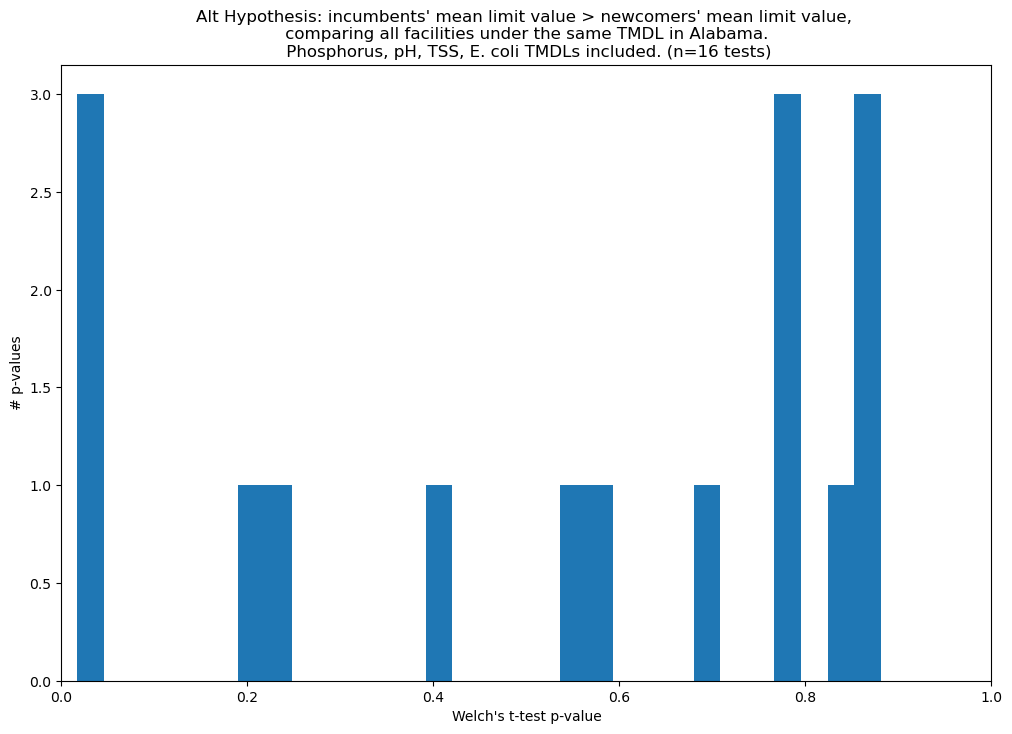

In [155]:
plt.style.use('default')
plt.figure(figsize=(12, 8))
plt.hist(p_values, bins=30);
plt.xlim((0, 1));
plt.xlabel('Welch\'s t-test p-value')
plt.ylabel('# p-values')
plt.title(
    'Alt Hypothesis: incumbents\' mean limit value > newcomers\' mean limit value, \n comparing all facilities under the same TMDL in Alabama. \n Phosphorus, pH, TSS, E. coli TMDLs included. (n=' + str(
        len(p_values)) + ' tests)')